# Ad Sales Data
# Revenue Regression
Code link: https://www.kaggle.com/code/akshaysunil07/ad-tech-revenue-regression/notebook 

# Installing packages section

In [ ]:
# Installing packages set for without init script
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

In [ ]:
!pip install seaborn

# Restart and clear outputs

# Importing packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

In [ ]:
#df1 = pd.read_csv('C:/Users/10738686/Downloads/ad_sales_data/ad_sales.csv')
#df = df1.sample(n=50000,random_state=10).reset_index(drop=True)

In [ ]:
# Importing data from snowflake

In [3]:
# snowflake.get_connection(connection_name="ME_AD_SALES_CXN")

from fosforio import snowflake
from fosforio import get_dataframe

snowflake.get_connection(connection_name="ME_AD_SALES_CXN")

Connection object created: <snowflake.connector.connection.SnowflakeConnection object at 0x7f2a264e4280>
Please close the connection after use!


In [4]:
df = get_dataframe("AD_SALES_IMP")
df_all = get_dataframe("AD_TECH_INPUT")

Reading dataframe from snowflake native connector
Reading dataframe from snowflake native connector


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   DATE                     567291 non-null  object 
 1   SITE_ID                  567291 non-null  int16  
 2   AD_TYPE_ID               567291 non-null  int8   
 3   GEO_ID                   567291 non-null  int16  
 4   DEVICE_CATEGORY_ID       567291 non-null  int8   
 5   ADVERTISER_ID            567291 non-null  int16  
 6   ORDER_ID                 567291 non-null  int16  
 7   LINE_ITEM_TYPE_ID        567291 non-null  int8   
 8   OS_ID                    567291 non-null  int8   
 9   INTEGRATION_TYPE_ID      567291 non-null  int8   
 10  MONETIZATION_CHANNEL_ID  567291 non-null  int8   
 11  AD_UNIT_ID               567291 non-null  int16  
 12  TOTAL_IMPRESSIONS        567291 non-null  int16  
 13  TOTAL_REVENUE            567291 non-null  float64
 14  VIEW

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   AD_DATE                  567291 non-null  object 
 1   SITE_ID                  567291 non-null  int16  
 2   AD_TYPE_ID               567291 non-null  int8   
 3   GEO_ID                   567291 non-null  int16  
 4   DEVICE_CATEGORY_ID       567291 non-null  int8   
 5   ADVERTISER_ID            567291 non-null  int16  
 6   ORDER_ID                 567291 non-null  int16  
 7   LINE_ITEM_TYPE_ID        567291 non-null  int8   
 8   OS_ID                    567291 non-null  int8   
 9   MONETIZATION_CHANNEL_ID  567291 non-null  int8   
 10  AD_UNIT_ID               567291 non-null  int16  
 11  TOTAL_IMPRESSIONS        567291 non-null  int16  
 12  TOTAL_REVENUE            567291 non-null  float64
 13  VIEWABLE_IMPRESSIONS     567291 non-null  int16  
 14  MEAS

In [7]:
df.columns = df.columns.str.lower()
df_all.columns = df_all.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     567291 non-null  object 
 1   site_id                  567291 non-null  int16  
 2   ad_type_id               567291 non-null  int8   
 3   geo_id                   567291 non-null  int16  
 4   device_category_id       567291 non-null  int8   
 5   advertiser_id            567291 non-null  int16  
 6   order_id                 567291 non-null  int16  
 7   line_item_type_id        567291 non-null  int8   
 8   os_id                    567291 non-null  int8   
 9   integration_type_id      567291 non-null  int8   
 10  monetization_channel_id  567291 non-null  int8   
 11  ad_unit_id               567291 non-null  int16  
 12  total_impressions        567291 non-null  int16  
 13  total_revenue            567291 non-null  float64
 14  view

In [ ]:
# from fosforio import snowflake

# df1 = snowflake.get_dataframe("ME_AD_SALES_SCHEMA.AD_SALES_IMP")
# df1 = get_dataframe("AD_SALES_IMP")
# df1

# Exploratory data analysis

In [8]:
cat_col=['date','geo_id','order_id','site_id', 'ad_type_id','device_category_id', 'advertiser_id',
         'line_item_type_id', 'os_id','monetization_channel_id']
scat_col = ['site_id', 'ad_type_id','device_category_id', 'advertiser_id',
         'line_item_type_id', 'os_id','monetization_channel_id']
num_col=list(df.select_dtypes(np.number).columns)

In [9]:
import seaborn as sns

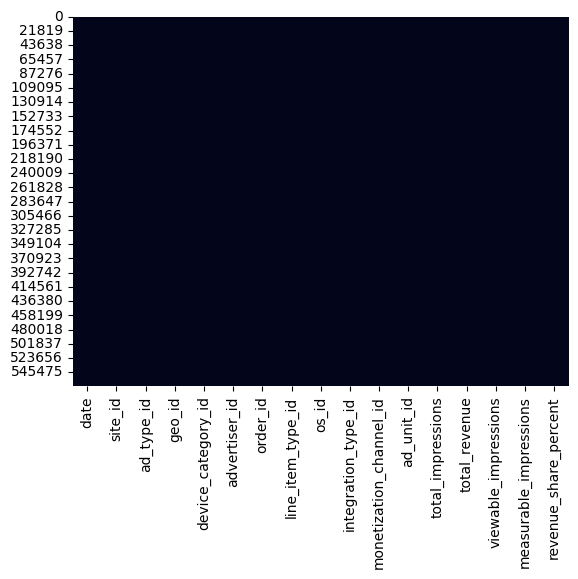

In [10]:
sns.heatmap(df.isnull(),cbar=False,cbar_kws={'color':'r'})
plt.show()

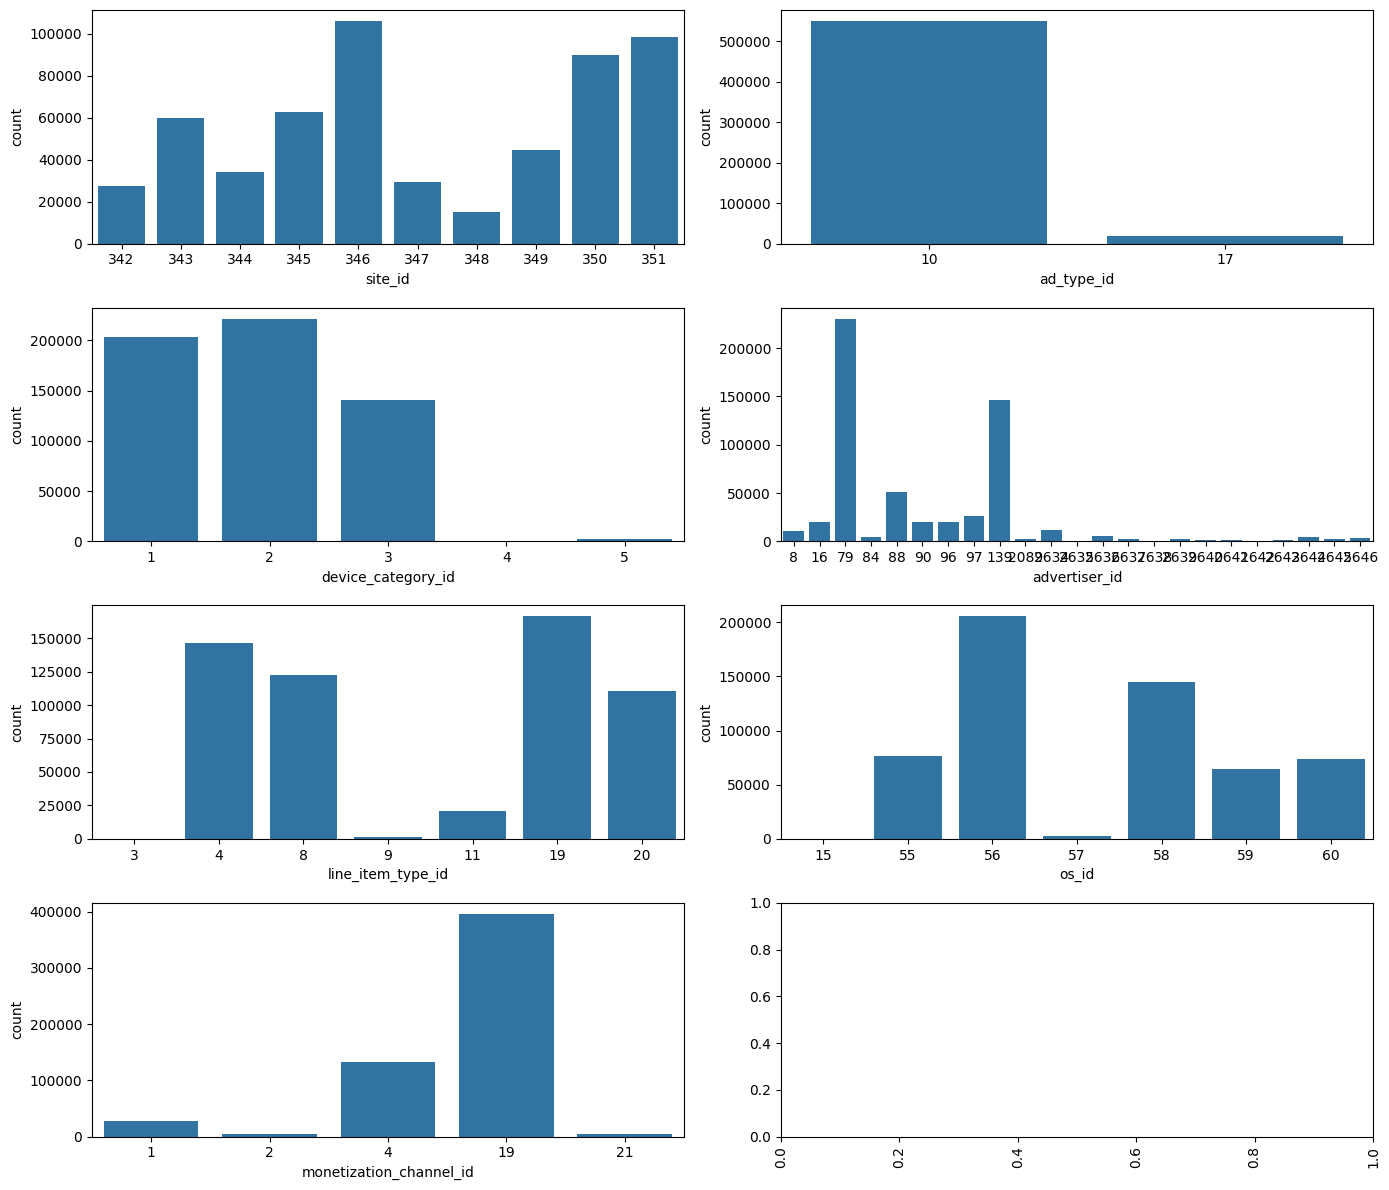

In [11]:
fig, ax = plt.subplots(4,2, figsize=(14,12))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i,col in enumerate(scat_col):
    sns.countplot(data=df,x=col,ax=axes_[i])
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.tight_layout()

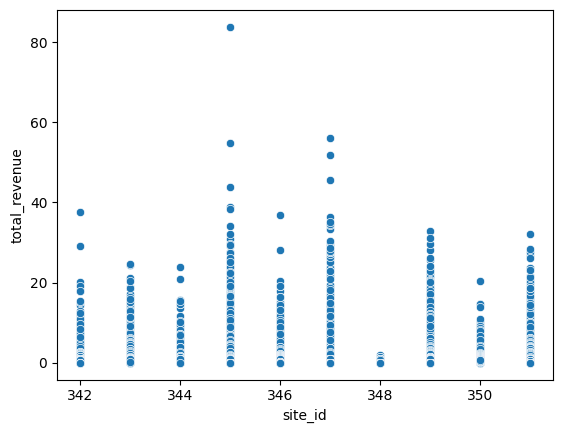

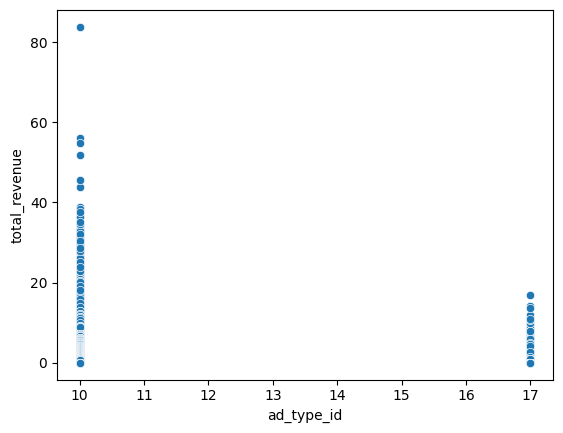

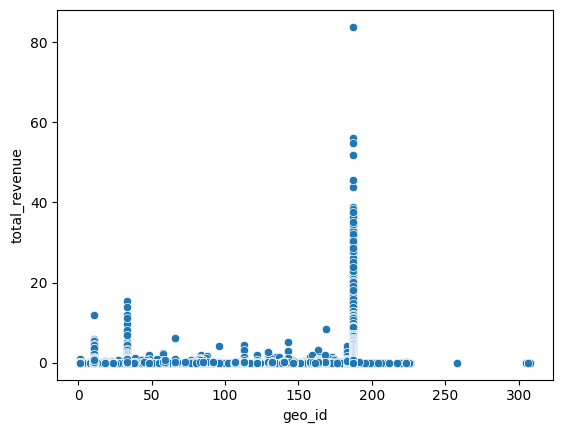

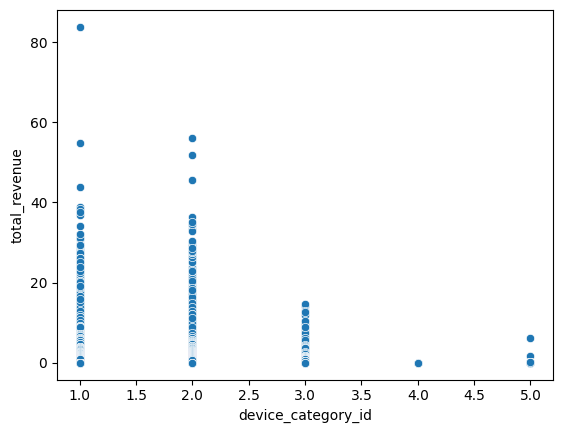

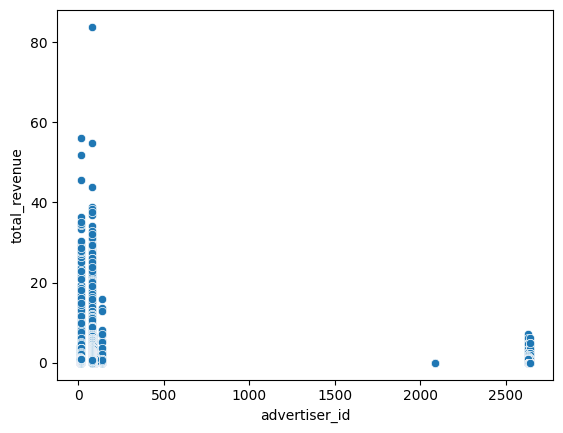

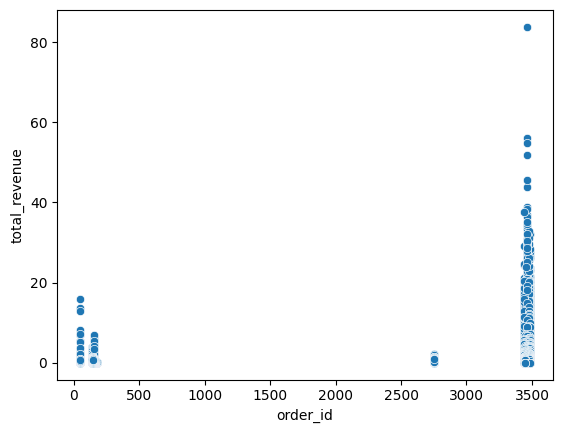

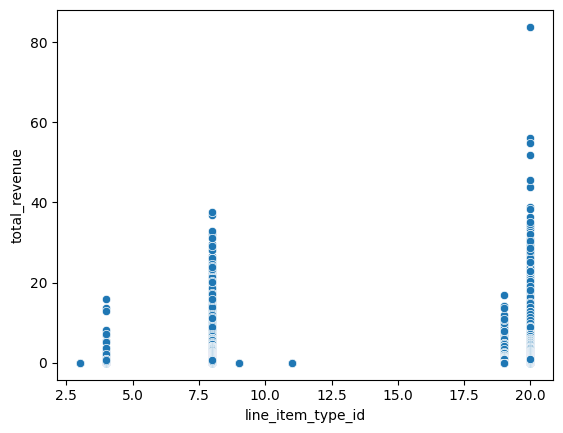

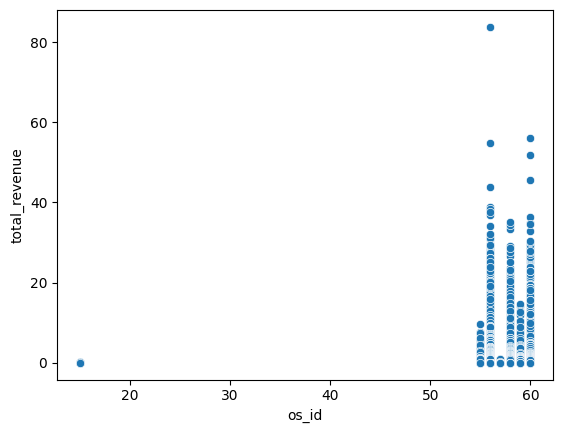

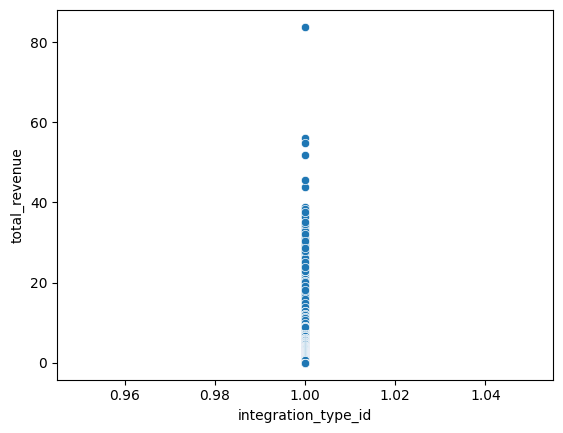

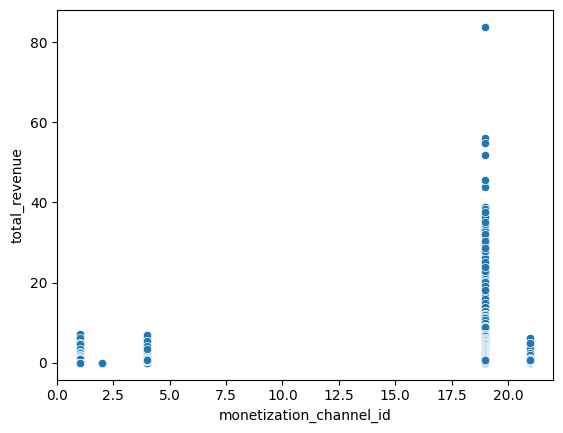

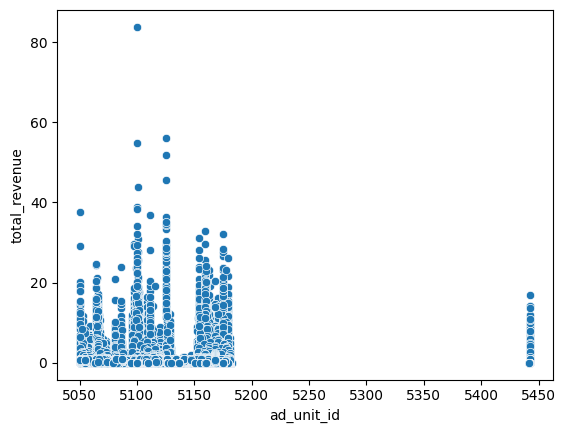

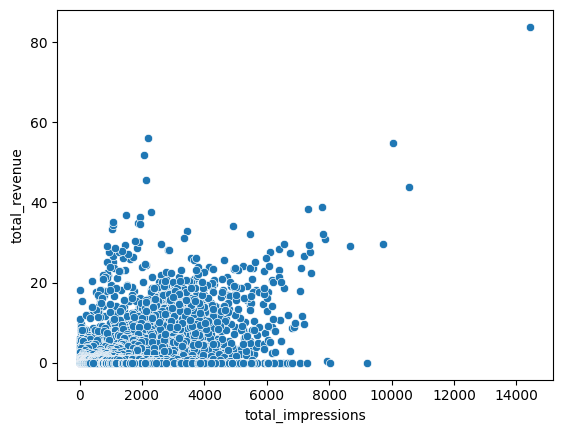

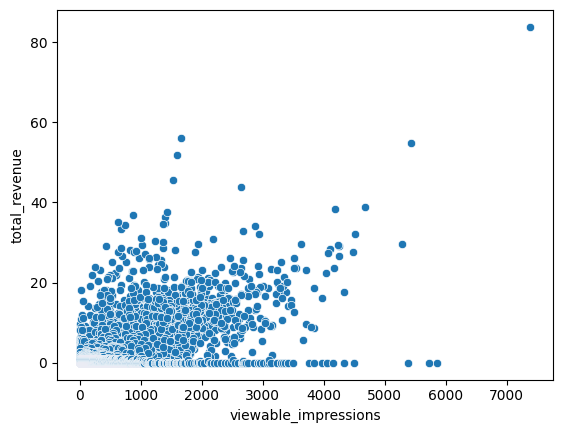

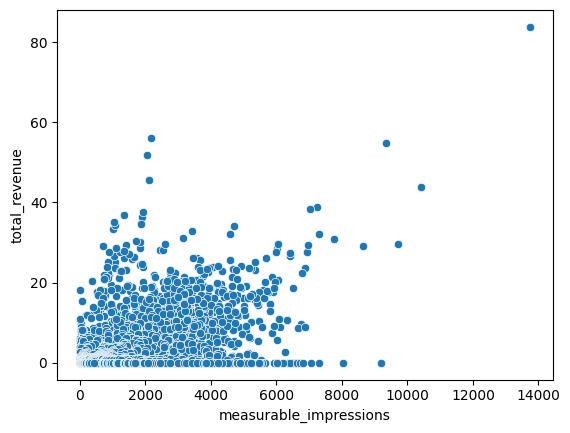

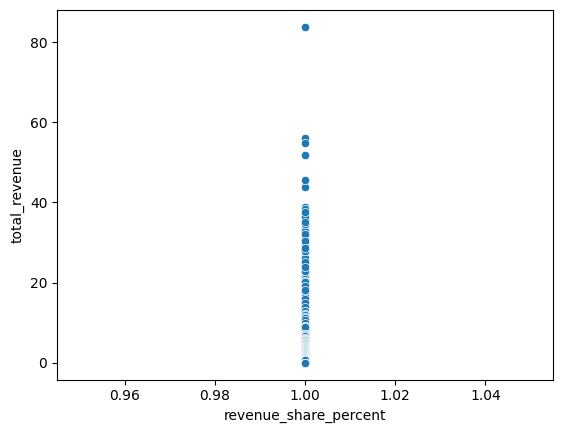

In [12]:
for i in num_col:
    if i!='total_revenue':
        sns.scatterplot(data=df,x=i,y='total_revenue')
        plt.show()

In [13]:
df.max()

date                       30-06-2024 00:00
site_id                                 351
ad_type_id                               17
geo_id                                  308
device_category_id                        5
advertiser_id                          2646
order_id                               3489
line_item_type_id                        20
os_id                                    60
integration_type_id                       1
monetization_channel_id                  21
ad_unit_id                             5443
total_impressions                     14452
total_revenue                        83.822
viewable_impressions                   7392
measurable_impressions                13756
revenue_share_percent                     1
dtype: object

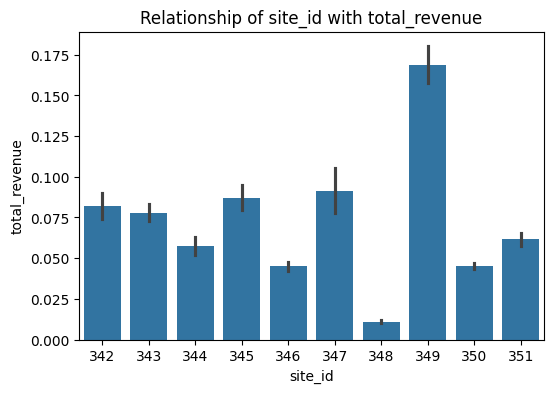

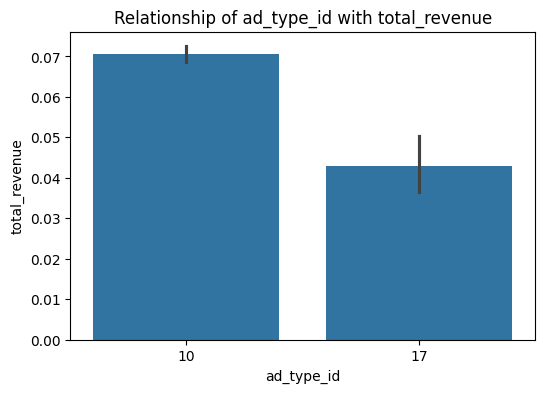

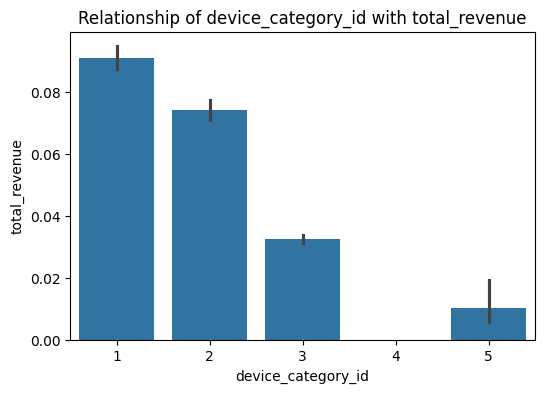

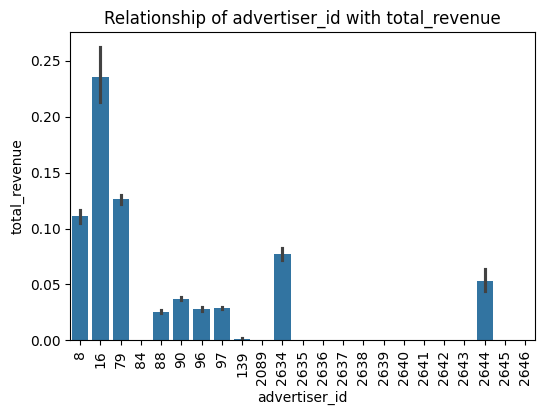

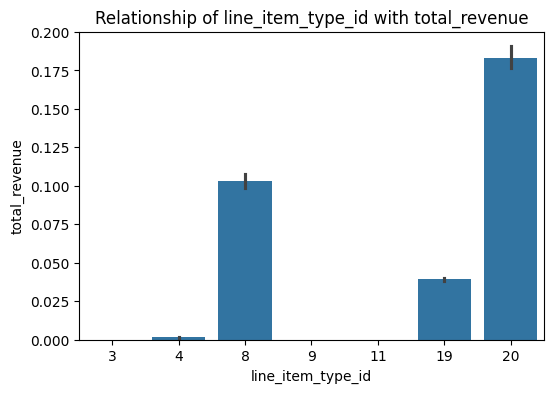

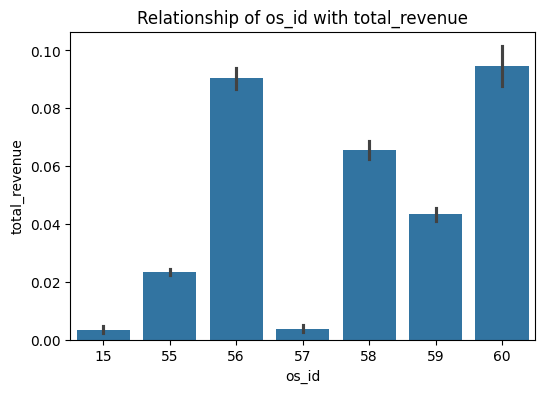

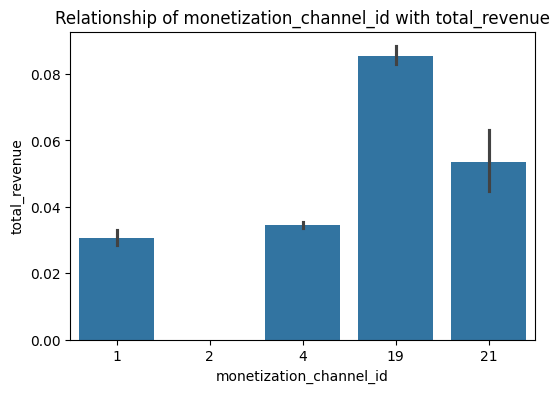

In [14]:
for col in (scat_col):
    title='Relationship of '+col+' with total_revenue'
    plt.figure(figsize=(6,4))
    sns.barplot(y=df['total_revenue'],x=df[col])
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

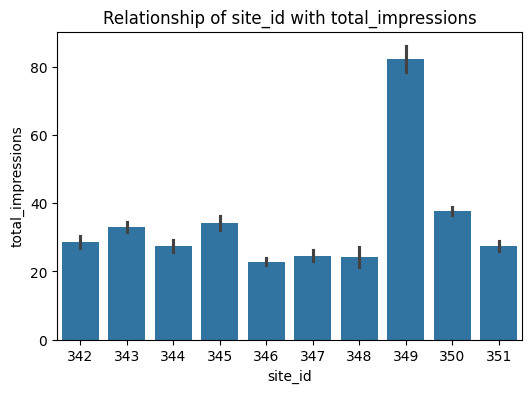

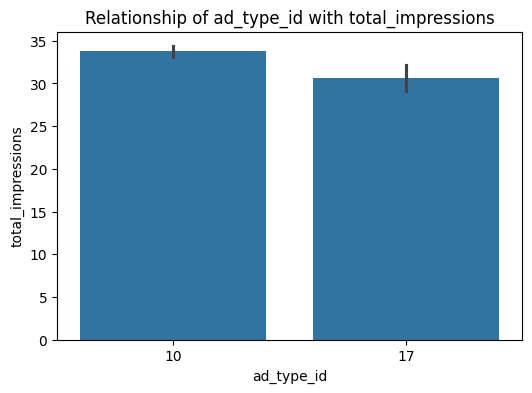

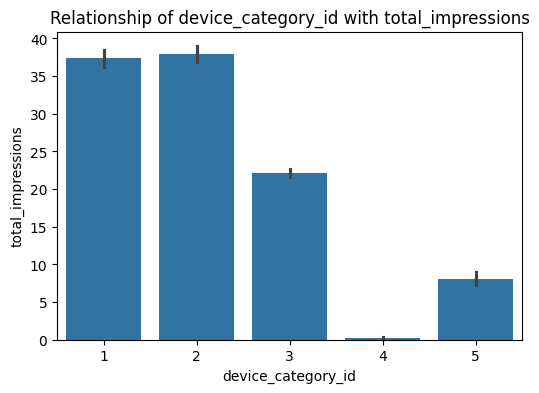

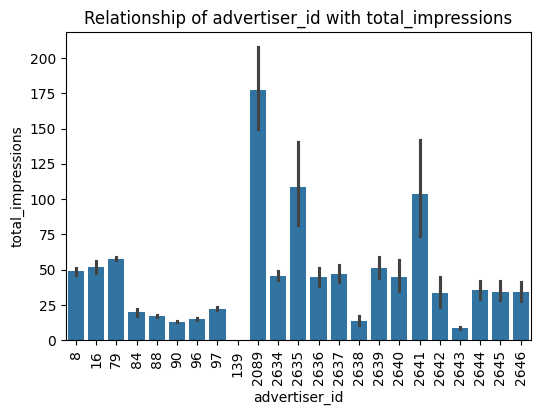

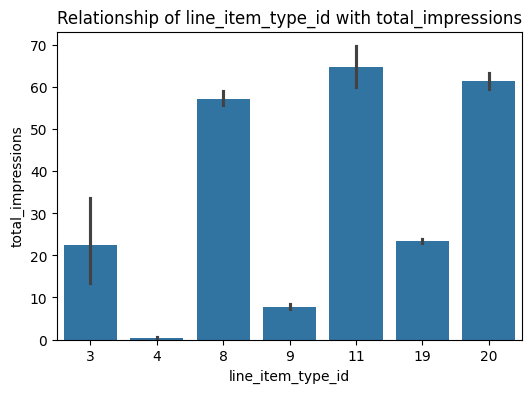

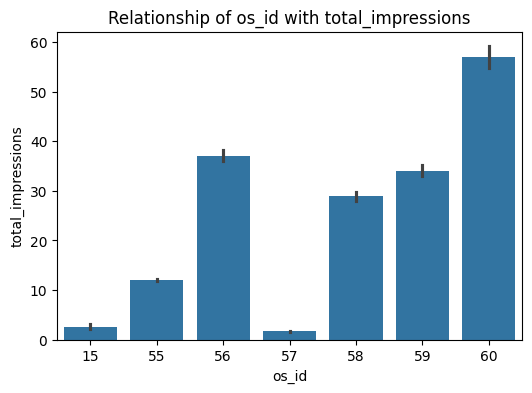

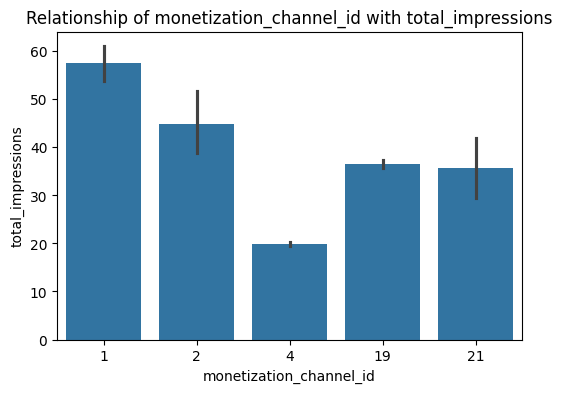

In [15]:
for col in (scat_col):
    title='Relationship of '+ col +' with total_impressions'
    plt.figure(figsize=(6,4))
    sns.barplot(y=df['total_impressions'],x=df[col],)
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

In [16]:
cat_col=['date','geo_id','order_id','site_id', 'ad_type_id','device_category_id', 'advertiser_id',
         'line_item_type_id', 'os_id','monetization_channel_id']

scat_col = ['site_id', 'ad_type_id','device_category_id', 'advertiser_id',
         'line_item_type_id', 'os_id','monetization_channel_id']

for i in cat_col:
    df[i]=df[i].astype('object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     567291 non-null  object 
 1   site_id                  567291 non-null  object 
 2   ad_type_id               567291 non-null  object 
 3   geo_id                   567291 non-null  object 
 4   device_category_id       567291 non-null  object 
 5   advertiser_id            567291 non-null  object 
 6   order_id                 567291 non-null  object 
 7   line_item_type_id        567291 non-null  object 
 8   os_id                    567291 non-null  object 
 9   integration_type_id      567291 non-null  int8   
 10  monetization_channel_id  567291 non-null  object 
 11  ad_unit_id               567291 non-null  int16  
 12  total_impressions        567291 non-null  int16  
 13  total_revenue            567291 non-null  float64
 14  view

In [18]:
df.drop(['ad_unit_id','revenue_share_percent','integration_type_id'],axis=1,inplace=True)
df.drop(['ad_type_id','site_id','advertiser_id'],axis=1,inplace=True)
df.drop(['date','geo_id','order_id'],axis=1,inplace=True)

In [19]:
df.select_dtypes(object)

,device_category_id,line_item_type_id,os_id,monetization_channel_id
0,2,19,58,4
1,2,19,60,4
2,2,19,58,4
3,3,20,59,19
4,3,20,59,19
...,...,...,...,...
567286,1,11,56,1
567287,1,11,56,1
567288,1,11,56,1
567289,2,11,60,1


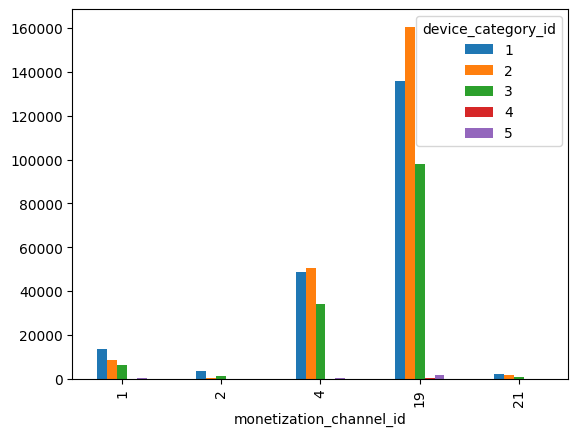

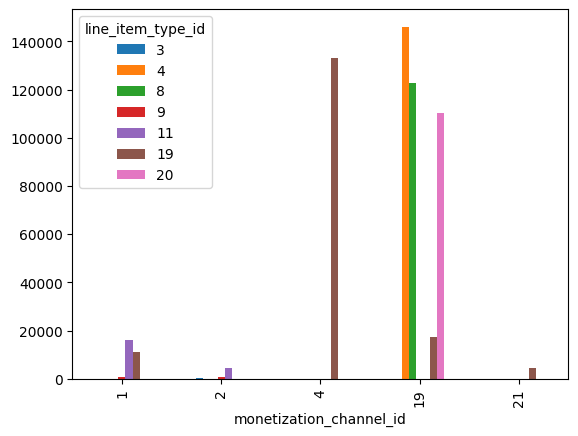

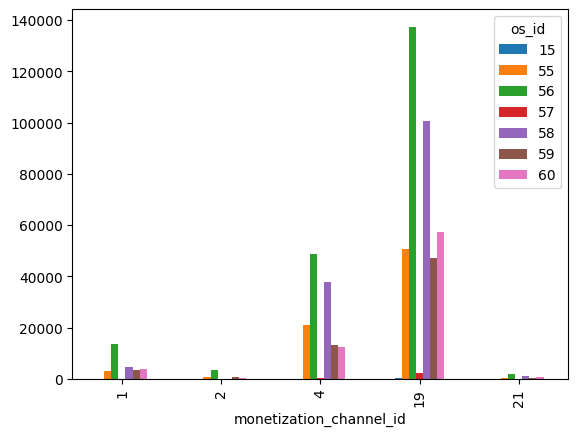

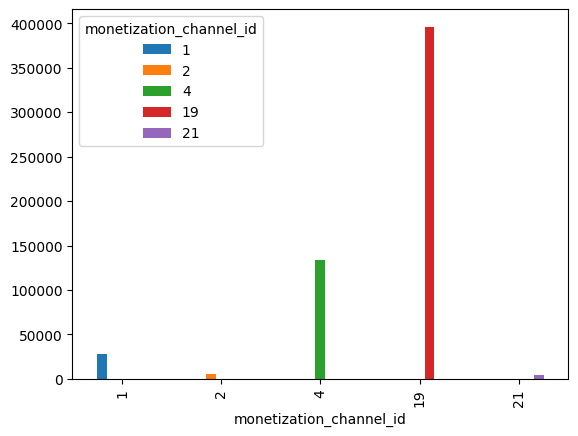

In [20]:
for i in df.select_dtypes(object).columns:
    pd.crosstab(df['monetization_channel_id'],df[i]).plot(kind='bar')
    plt.show()

# Predictive Modelling

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   device_category_id       567291 non-null  object 
 1   line_item_type_id        567291 non-null  object 
 2   os_id                    567291 non-null  object 
 3   monetization_channel_id  567291 non-null  object 
 4   total_impressions        567291 non-null  int16  
 5   total_revenue            567291 non-null  float64
 6   viewable_impressions     567291 non-null  int16  
 7   measurable_impressions   567291 non-null  int16  
dtypes: float64(1), int16(3), object(4)
memory usage: 24.9+ MB


In [22]:
Xd = df.drop('total_revenue',axis=1)
y = df['total_revenue']

In [23]:
X = pd.get_dummies(Xd,drop_first=True)

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   total_impressions           567291 non-null  int16
 1   viewable_impressions        567291 non-null  int16
 2   measurable_impressions      567291 non-null  int16
 3   device_category_id_2        567291 non-null  bool 
 4   device_category_id_3        567291 non-null  bool 
 5   device_category_id_4        567291 non-null  bool 
 6   device_category_id_5        567291 non-null  bool 
 7   line_item_type_id_4         567291 non-null  bool 
 8   line_item_type_id_8         567291 non-null  bool 
 9   line_item_type_id_9         567291 non-null  bool 
 10  line_item_type_id_11        567291 non-null  bool 
 11  line_item_type_id_19        567291 non-null  bool 
 12  line_item_type_id_20        567291 non-null  bool 
 13  os_id_55                    567291 non-null 

In [25]:
pc_col = ['total_impressions', 'viewable_impressions', 'measurable_impressions']

In [26]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [27]:
X[pc_col] = pd.DataFrame(ss.fit_transform(X[pc_col]),columns=[pc_col])

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [ ]:
# Applying PCA (principal component analysis)

In [29]:
from sklearn.decomposition import PCA
pc_col=['total_impressions', 'viewable_impressions', 'measurable_impressions']
pca = PCA()
pca.fit(X[pc_col])

PCA()

In [30]:
np.cumsum(pca.explained_variance_ratio_)

array([0.94556992, 0.99831945, 1.        ])

In [31]:
pca = PCA(n_components=1)
cc = pca.fit_transform(X_train[pc_col])
cd = pca.transform(X_test[pc_col])

In [32]:
X_train['PC']=cc
X_test['PC']=cd

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 453832 entries, 250056 to 485815
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   total_impressions           453832 non-null  float64
 1   viewable_impressions        453832 non-null  float64
 2   measurable_impressions      453832 non-null  float64
 3   device_category_id_2        453832 non-null  bool   
 4   device_category_id_3        453832 non-null  bool   
 5   device_category_id_4        453832 non-null  bool   
 6   device_category_id_5        453832 non-null  bool   
 7   line_item_type_id_4         453832 non-null  bool   
 8   line_item_type_id_8         453832 non-null  bool   
 9   line_item_type_id_9         453832 non-null  bool   
 10  line_item_type_id_11        453832 non-null  bool   
 11  line_item_type_id_19        453832 non-null  bool   
 12  line_item_type_id_20        453832 non-null  bool   
 13  os_id_55      

In [34]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113459 entries, 542543 to 94897
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   total_impressions           113459 non-null  float64
 1   viewable_impressions        113459 non-null  float64
 2   measurable_impressions      113459 non-null  float64
 3   device_category_id_2        113459 non-null  bool   
 4   device_category_id_3        113459 non-null  bool   
 5   device_category_id_4        113459 non-null  bool   
 6   device_category_id_5        113459 non-null  bool   
 7   line_item_type_id_4         113459 non-null  bool   
 8   line_item_type_id_8         113459 non-null  bool   
 9   line_item_type_id_9         113459 non-null  bool   
 10  line_item_type_id_11        113459 non-null  bool   
 11  line_item_type_id_19        113459 non-null  bool   
 12  line_item_type_id_20        113459 non-null  bool   
 13  os_id_55       

In [35]:
X_train.drop(pc_col,axis=1,inplace=True)
X_test.drop(pc_col,axis=1,inplace=True)

In [38]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [39]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error

In [ ]:
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)

print('Model 1: Linear regression')
print('Train')
print('R2 Score:',r2_score(y_train,y_train_pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(y_train,y_train_pred))

y_test_pred=lr.predict(X_test)

print('\n\nTest')
print('R2 Score:',r2_score(y_test,y_test_pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(y_test,y_test_pred))

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
rfr = RandomForestRegressor()

rfr.fit(X_train,y_train)
y_train_pred=rfr.predict(X_train)

print('Model 2: Random forest regression- plain')
print('r2 Train',r2_score(y_train,y_train_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred=rfr.predict(X_test)

print('\n\nTest')
print('\nr2 Test',r2_score(y_test,y_test_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

Model 2: Random forest regression- plain
r2 Train 0.9451985567954176
RMSE Train: 0.16546934453326087


Test

r2 Test 0.6235132393589511
RMSE Train: 0.45407251167216267


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [ ]:
rfrbest1 = {'max_depth': 12,
 'max_features': 8,
 'min_samples_leaf': 3,
 'n_estimators': 160}

In [ ]:
rfr1 = RandomForestRegressor(**rfrbest1)

rfr1.fit(X_train,y_train)
y_train_pred=rfr1.predict(X_train)

print('Model 3: Random forest regression- best 1')
print('r2 Train',r2_score(y_train,y_train_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred=rfr1.predict(X_test)

print('\n\nTest')
print('\nr2 Test',r2_score(y_test,y_test_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

In [ ]:
# rfr = RandomForestRegressor() 
#param_dist = {'n_estimators':sp_randint(25,250), 'max_features':sp_randint(1,24), 'max_depth':sp_randint(2,15), 
#                                                                'min_samples_leaf':sp_randint(1,50)} rsearch = RandomizedSearchCV(rfr,param_distributions=param_dist,scoring='r2', 
#                                                                  n_iter=10,cv=3,n_jobs=-1,random_state=4) rsearch.fit(X_train,y_train) rsearch.best_params_

In [ ]:
rfrbest2 = {'max_depth': 12,
 'max_features': 15,
 'min_samples_leaf': 6,
 'n_estimators': 154}

In [ ]:
rfr2 = RandomForestRegressor(**rfrbest2)

rfr2.fit(X_train,y_train)
y_train_pred = rfr2.predict(X_train)

print('Model 4: Random forest regression- best 2')
print('r2 Train',r2_score(y_train,y_train_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred = rfr2.predict(X_test)

print('\n\nTest')
print('\nr2 Test',r2_score(y_test,y_test_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

In [ ]:
#Snce RFR1 is good, Im using that model:
rfr1 = RandomForestRegressor(**rfrbest1)

rfr1.fit(X_train,y_train)
y_train_pred=rfr1.predict(X_train)

print('Model 3: Random forest regression- best 1')
print('r2 Train',r2_score(y_train,y_train_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred=rfr1.predict(X_test)

print('\n\nTest')
print('\nr2 Test',r2_score(y_test,y_test_pred))
print('RMSE Train:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   total_impressions           567291 non-null  float64
 1   viewable_impressions        567291 non-null  float64
 2   measurable_impressions      567291 non-null  float64
 3   device_category_id_2        567291 non-null  bool   
 4   device_category_id_3        567291 non-null  bool   
 5   device_category_id_4        567291 non-null  bool   
 6   device_category_id_5        567291 non-null  bool   
 7   line_item_type_id_4         567291 non-null  bool   
 8   line_item_type_id_8         567291 non-null  bool   
 9   line_item_type_id_9         567291 non-null  bool   
 10  line_item_type_id_11        567291 non-null  bool   
 11  line_item_type_id_19        567291 non-null  bool   
 12  line_item_type_id_20        567291 non-null  bool   
 13  os_id_55      

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 453832 entries, 250056 to 485815
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   device_category_id_2        453832 non-null  bool   
 1   device_category_id_3        453832 non-null  bool   
 2   device_category_id_4        453832 non-null  bool   
 3   device_category_id_5        453832 non-null  bool   
 4   line_item_type_id_4         453832 non-null  bool   
 5   line_item_type_id_8         453832 non-null  bool   
 6   line_item_type_id_9         453832 non-null  bool   
 7   line_item_type_id_11        453832 non-null  bool   
 8   line_item_type_id_19        453832 non-null  bool   
 9   line_item_type_id_20        453832 non-null  bool   
 10  os_id_55                    453832 non-null  bool   
 11  os_id_56                    453832 non-null  bool   
 12  os_id_57                    453832 non-null  bool   
 13  os_id_58      

In [48]:
y_df= pd.DataFrame(y)
y_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   total_revenue  567291 non-null  float64
dtypes: float64(1)
memory usage: 4.3 MB


In [49]:
y_train_df= pd.DataFrame(y_train)
y_train_df

,total_revenue
250056,0.0002
415671,0.0032
319747,0.0072
488332,0.0000
503367,0.0000
...,...
458492,0.0000
107578,0.0000
120705,0.0000
377541,0.0000


In [50]:
y_test_df= pd.DataFrame(y_test)
y_test_df

,total_revenue
542543,0.0010
317500,0.0064
553277,0.0346
265376,0.0006
119817,0.0000
...,...
295676,0.0028
118927,0.0000
8044,0.0000
300743,0.0034


In [51]:
y_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113459 entries, 542543 to 94897
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   total_revenue  113459 non-null  float64
dtypes: float64(1)
memory usage: 1.7 MB


In [52]:
y_train_pred_df = pd.DataFrame(y_train_pred, columns=['y_pred'])
y_train_pred_df

,y_pred
0,0.004876
1,0.014497
2,0.003233
3,0.000000
4,0.012856
...,...
453827,0.004415
453828,0.000000
453829,0.000000
453830,0.003802


In [53]:
y_test_pred_df = pd.DataFrame(y_test_pred,columns=['y_pred'])
y_test_pred_df

,y_pred
0,0.003058
1,0.006234
2,2.739094
3,0.006234
4,0.004876
...,...
113454,0.013396
113455,0.000000
113456,0.000988
113457,0.023811


In [55]:
y_train_final= pd.concat([y_train_df, y_train_pred_df.set_index(y_train_df.index)], axis=1)
y_train_final

,total_revenue,y_pred
250056,0.0002,0.004876
415671,0.0032,0.014497
319747,0.0072,0.003233
488332,0.0000,0.000000
503367,0.0000,0.012856
...,...,...
458492,0.0000,0.004415
107578,0.0000,0.000000
120705,0.0000,0.000000
377541,0.0000,0.003802


In [56]:
y_test_final= pd.concat([y_test_df, y_test_pred_df.set_index(y_test_df.index)], axis=1)
y_test_final

,total_revenue,y_pred
542543,0.0010,0.003058
317500,0.0064,0.006234
553277,0.0346,2.739094
265376,0.0006,0.006234
119817,0.0000,0.004876
...,...,...
295676,0.0028,0.013396
118927,0.0000,0.000000
8044,0.0000,0.000988
300743,0.0034,0.023811


In [57]:
y_all = pd.concat([y_train_final, y_test_final])
y_all

,total_revenue,y_pred
250056,0.0002,0.004876
415671,0.0032,0.014497
319747,0.0072,0.003233
488332,0.0000,0.000000
503367,0.0000,0.012856
...,...,...
295676,0.0028,0.013396
118927,0.0000,0.000000
8044,0.0000,0.000988
300743,0.0034,0.023811


In [62]:
y_all.sort_index(axis=0, inplace = True)
y_all

,total_revenue,y_pred
0,0.0,0.013396
1,0.0,0.008561
2,0.0,0.010181
3,0.0,0.003864
4,0.0,0.001871
...,...,...
567286,0.0,0.237454
567287,0.0,0.237454
567288,0.0,1.164300
567289,0.0,1.173414


In [63]:
y_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 567291 entries, 0 to 567290
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   total_revenue  567291 non-null  float64
 1   y_pred         567291 non-null  float64
dtypes: float64(2)
memory usage: 13.0 MB


In [68]:
df_all

,ad_date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent,ad_type,ad_format,ad_media_type,device_type,city,city_code,population,city_lat,city_lon,line_item_group,line_item_type,monetization_channel,os_type
0,2024-06-18,350,10,33,3,79,3485,8,59,19,5168,2,0.0,0,2,1,interactive,in_feed,survey,phone,Los Angeles,CA,3820914,34.02,-118.41,guaranteed,standard,in-app_purchases,mac
1,2024-06-18,350,10,33,2,79,3485,8,60,19,5168,2,0.0,0,2,1,interactive,in_feed,survey,laptop,Los Angeles,CA,3820914,34.02,-118.41,guaranteed,standard,in-app_purchases,windows
2,2024-06-18,350,10,27,1,79,3485,8,56,19,5168,2,0.0,0,2,1,interactive,in_feed,survey,tablet,Orlando,FL,320742,28.41,-81.25,guaranteed,standard,in-app_purchases,android
3,2024-06-18,350,10,24,2,79,3485,8,60,19,5168,2,0.0,0,2,1,interactive,in_feed,survey,laptop,Jacksonville,FL,985843,30.34,-81.66,guaranteed,standard,in-app_purchases,windows
4,2024-06-18,350,10,21,1,79,3485,8,56,19,5168,2,0.0,0,2,1,interactive,in_feed,survey,tablet,Worcester,MA,207621,42.27,-71.81,guaranteed,standard,in-app_purchases,android
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567286,2024-07-09,349,10,187,1,2089,3445,11,56,1,5160,6792,0.0,4340,6788,1,interactive,retargetted,survey,tablet,New York,NY,8258035,40.66,-73.94,non_guaranteed,adsense,sponsorship,android
567287,2024-06-28,349,10,187,1,2089,3445,11,56,1,5160,6734,0.0,4498,6730,1,interactive,retargetted,survey,tablet,New York,NY,8258035,40.66,-73.94,non_guaranteed,adsense,sponsorship,android
567288,2024-07-09,348,10,187,1,2641,3484,11,56,1,5137,6822,0.0,5392,6820,1,interactive,rewarded,reels,tablet,New York,NY,8258035,40.66,-73.94,non_guaranteed,adsense,sponsorship,android
567289,2024-06-21,349,10,187,2,2089,3445,11,60,1,5159,8024,0.0,5728,8024,1,interactive,retargetted,rich_media,laptop,New York,NY,8258035,40.66,-73.94,non_guaranteed,adsense,sponsorship,windows


In [71]:
check1 = pd.concat([df_all, y_all], axis = 1 True)
check1

TypeError: concat() got an unexpected keyword argument 'inplace'

In [ ]:
y_train_bkp = y_train_df.copy()
y_train_df.reset_index(drop=True, inplace=True)
y_train_df

In [ ]:
y_train.info()

In [ ]:
y_train_all = pd.concat([y_train_df,y_train_pred_df],axis = 1)
y_train_all

In [ ]:
y_train_final = pd.merge(y_train_bkp, y_train_all, on='total_revenue')
y_train_final

In [ ]:
y_train_pred_df = pd.DataFrame(y_train_pred)  
y_test_pred_df = pd.DataFrame(y_test_pred)  

In [ ]:
y_train

In [ ]:
y_train_df = pd.DataFrame(y_train)  

In [ ]:
y_train_club = pd.concat([y_train_df,y_train_pred_df])
y_train_club

In [ ]:
X_train

In [ ]:
train_df = X_train.copy()

In [ ]:
train_df['pred'] = y_train_pred_df

In [ ]:
train_df

In [ ]:
X_train

In [ ]:
rfr.predict(X_train.iloc[:4])

In [ ]:
df_out = pd.merge(X_train,y_train_pred_df, how = 'left',left_index = True, right_index = True)
df_out.

In [ ]:
df_out.shape

In [ ]:
train_df = pd.concat([X_train, y_train,y_train_pred_df])
test_df = pd.concat([X_test, y_test,y_test_pred_df])


In [ ]:
train_df.info()